\newpage

# Appendix I

In [1]:
# First of all, some general python and eWaterCycle libraries need to be imported:
# general python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from scipy.optimize import minimize

#niceties
from rich import print
import seaborn as sns
sns.set()

# general eWaterCycle
import ewatercycle
import ewatercycle.models
import ewatercycle.forcing

In [2]:
# As stated in chapter 3, eWaterCycle provides access to the Caravan dataset, from which a Camel dataset of the catchment of the Wien River is loaded.
camelsgb_id = "lamah_208082"

In [3]:
# calibration dates on 75% of experiment dates

experiment_start_date = "1981-08-01T00:00:00Z"
experiment_end_date = "2018-01-01T00:00:00Z"

calibration_start_time = experiment_start_date
calibration_end_time = "2007-08-31T00:00:00Z"

validation_start_time = "2007-09-01T00:00:00Z" 
validation_end_time = experiment_end_date

In [4]:
# Even though we don't use caravan data as forcing, we still call it forcing
# because it is generated using the forcing module of eWaterCycle
forcing_path_caravan = Path.home() / "forcing" / camelsgb_id / "caravan"
forcing_path_caravan.mkdir(exist_ok=True, parents=True)

# If someone has prepared forcing for you, this path needs to be changed to that location. 
prepared_forcing_path_caravan_central = Path("location/of/forcing/data")

In [5]:

# load data that you or someone else generated previously
camelsgb_forcing = ewatercycle.forcing.sources['CaravanForcing'].load(Path("/home/thirza/forcing/lamah_208082/caravan"))


In [6]:
# Above, it can be seen that the forcing data contains precipitation, potential evaporation, discharge and the near-surface temperatures (tas). 
# For this research, only the discharge data is relevant. The discharge data is loaded from the forcing below.

ds_forcing = xr.open_mfdataset([camelsgb_forcing['Q']])

In [7]:

#               Si,  Su, Sf, Ss, Sp
s_0 = np.array([0,  100,  0,  5, 0])
S_names = ["Interception storage", "Unsaturated Rootzone Storage", "Fastflow storage", "Slowflow storage", "Groundwater storage"]

p_names = ["$I_{max}$",  "$C_e$",  "$Su_{max}$", "β",  "$P_{max}$",  "$T_{lag}$",   "$K_f$",   "$K_s$", "FM"]
param_names = ["Imax","Ce",  "Sumax", "beta",  "Pmax",  "Tlag",   "Kf",   "Ks", "FM"]


In [8]:
result = [7.70574780e-07, 1.32351315e+00, 1.00047603e+02, 3.89427105e+00,
       6.66366529e-01, 4.30576783e-02, 1.00508560e+00, 1.94023052e+00,
       4.58706486e-01]

In [9]:
par = result
model = ewatercycle.models.HBVLocal(forcing=camelsgb_forcing)
config_file, _ = model.setup(parameters=par, initial_storage=s_0)
model.initialize(config_file)


In [10]:
Q_m = []
time = []
while model.time < model.end_time:
    model.update()
    Q_m.append(model.get_value("Q")[0])
    time.append(pd.Timestamp(model.time_as_datetime))
model.finalize()

In [11]:
model_output = pd.Series(data=Q_m, name="Modelled_discharge", index=time)

In [12]:
df = pd.DataFrame(model_output)
Q_pandas = ds_forcing["Q"].to_dataframe()
calibration_start_time = pd.to_datetime(calibration_start_time)
calibration_end_time = pd.to_datetime(calibration_end_time)

df.index = df.index.tz_localize(None)  # Remove timezone
Q_pandas.index = Q_pandas.index.tz_localize(None)
calibration_start_time = calibration_start_time.tz_localize(None)
calibration_end_time = calibration_end_time.tz_localize(None)

model_output_filtered1 = model_output.loc[calibration_start_time:calibration_end_time]
ds_forcing_filtered1 = ds_forcing["Q"].loc[calibration_start_time:calibration_end_time]

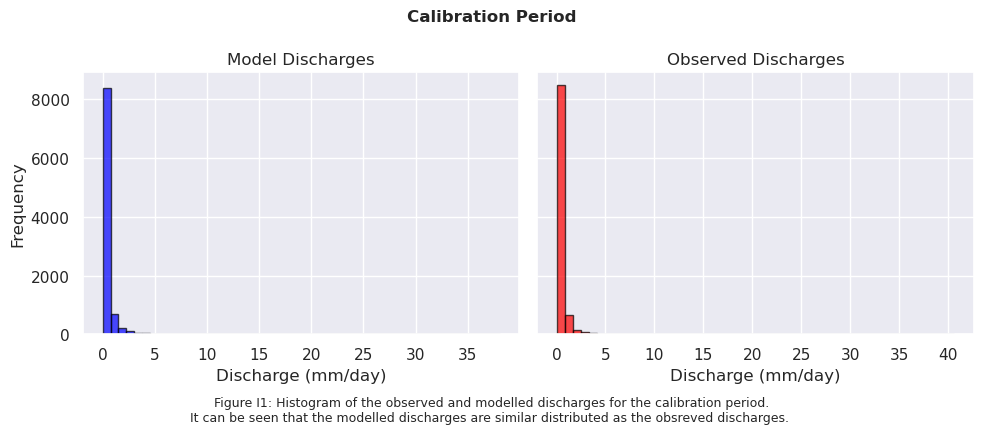

In [18]:
# Sort data from high to low
sorted_model_data = np.sort(model_output_filtered1)[::-1]  
sorted_obs_data = np.sort(ds_forcing_filtered1)[::-1]  

# Create figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)  

# Histogram for Model Data
axes[0].hist(sorted_model_data, bins=50, color='blue', edgecolor='black', alpha=0.7)
axes[0].set_title('Model Discharges')
axes[0].set_xlabel('Discharge (mm/day)')
axes[0].set_ylabel('Frequency')

# Histogram for Observed Data
axes[1].hist(sorted_obs_data, bins=50, color='red', edgecolor='black', alpha=0.7)
axes[1].set_title('Observed Discharges')
axes[1].set_xlabel('Discharge (mm/day)')

# Add a shared caption below the plots
fig.text(0.5, -0.05, 
         "Figure I1: Histogram of the observed and modelled discharges for the calibration period.\n"
         "It can be seen that the modelled discharges are similar distributed as the obsreved discharges. ",
         ha="center", fontsize=9)

fig.suptitle("Calibration Period", fontsize=12, fontweight='bold')


plt.tight_layout()  # Adjust layout to fit everything nicely
plt.show()


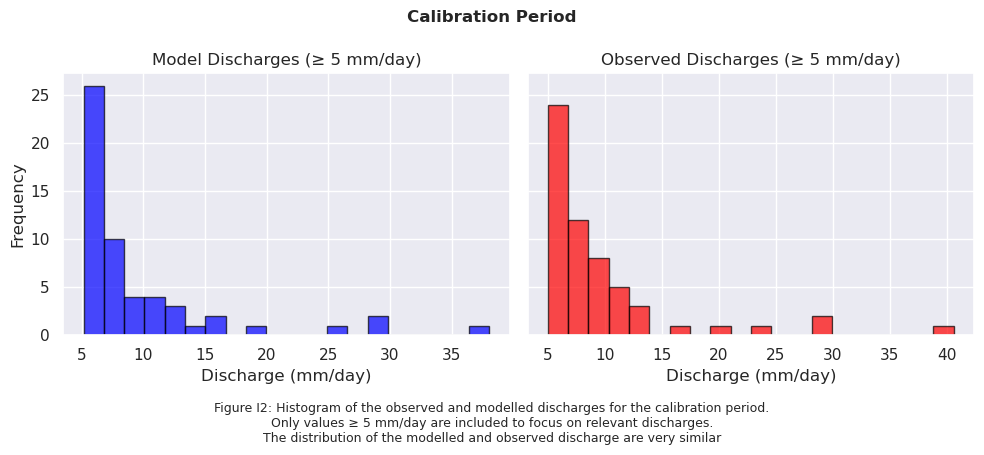

In [19]:

# Sort data from high to low and filter values >= 2 mm/day
sorted_model_data = np.sort(model_output_filtered1)[::-1]  
sorted_model_data = sorted_model_data[sorted_model_data >= 5]  

sorted_obs_data = np.sort(ds_forcing_filtered1)[::-1]  
sorted_obs_data = sorted_obs_data[sorted_obs_data >= 5]  

# Create figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)  

# Histogram for Model Data
axes[0].hist(sorted_model_data, bins=20, color='blue', edgecolor='black', alpha=0.7)
axes[0].set_title('Model Discharges (≥ 5 mm/day)')
axes[0].set_xlabel('Discharge (mm/day)')
axes[0].set_ylabel('Frequency')

# Histogram for Observed Data
axes[1].hist(sorted_obs_data, bins=20, color='red', edgecolor='black', alpha=0.7)
axes[1].set_title('Observed Discharges (≥ 5 mm/day)')
axes[1].set_xlabel('Discharge (mm/day)')

# Add a shared caption below the plots
fig.text(0.5, -0.1, 
         "Figure I2: Histogram of the observed and modelled discharges for the calibration period.\n"
         "Only values ≥ 5 mm/day are included to focus on relevant discharges.\n"
         "The distribution of the modelled and observed discharge are very similar",
         ha="center", fontsize=9)
fig.suptitle("Calibration Period", fontsize=12, fontweight='bold')
plt.tight_layout()  # Adjust layout to fit everything nicely
plt.show()

In [15]:
validation_start_time = pd.to_datetime(validation_start_time)
validation_end_time = pd.to_datetime(validation_end_time)

df.index = df.index.tz_localize(None)  # Remove timezone
Q_pandas.index = Q_pandas.index.tz_localize(None)
validation_start_time = validation_start_time.tz_localize(None)
validation_end_time = validation_end_time.tz_localize(None)

model_output_filtered2 = model_output.loc[validation_start_time:validation_end_time]
ds_forcing_filtered2 = ds_forcing["Q"].loc[validation_start_time:validation_end_time]

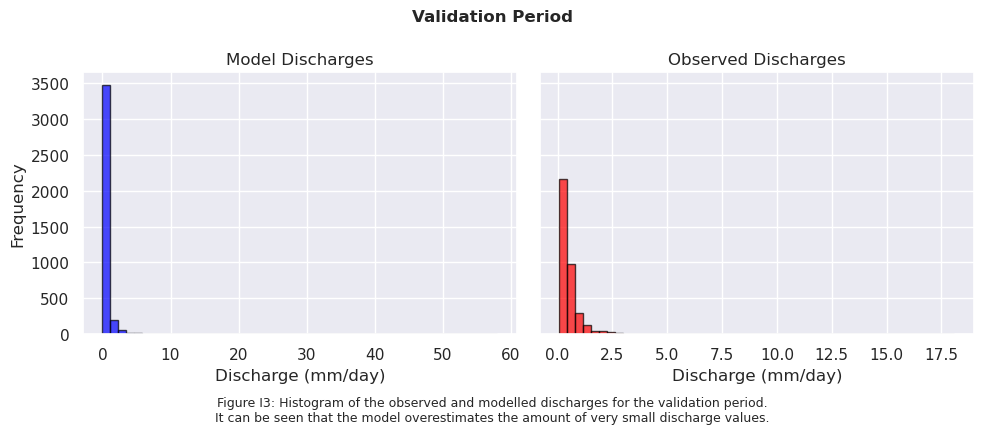

In [20]:

# Sort data from high to low
sorted_model_data = np.sort(model_output_filtered2)[::-1]  
sorted_obs_data = np.sort(ds_forcing_filtered2)[::-1]  

# Create figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)  

# Histogram for Model Data
axes[0].hist(sorted_model_data, bins=50, color='blue', edgecolor='black', alpha=0.7)
axes[0].set_title('Model Discharges')
axes[0].set_xlabel('Discharge (mm/day)')
axes[0].set_ylabel('Frequency')

# Histogram for Observed Data
axes[1].hist(sorted_obs_data, bins=50, color='red', edgecolor='black', alpha=0.7)
axes[1].set_title('Observed Discharges')
axes[1].set_xlabel('Discharge (mm/day)')

# Add a shared caption below the plots
fig.text(0.5, -0.05, 
         "Figure I3: Histogram of the observed and modelled discharges for the validation period.\n"
         "It can be seen that the model overestimates the amount of very small discharge values.",
         ha="center", fontsize=9)
fig.suptitle("Validation Period", fontsize=12, fontweight='bold')
plt.tight_layout()  # Adjust layout to fit everything nicely
plt.show()


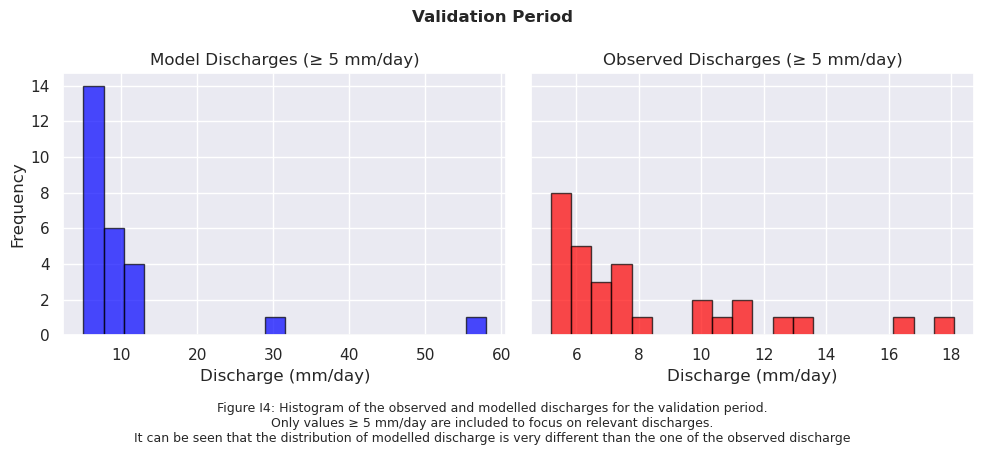

In [21]:

# Sort data from high to low and filter values >= 2 mm/day
sorted_model_data = np.sort(model_output_filtered2)[::-1]  
sorted_model_data = sorted_model_data[sorted_model_data >= 5]  

sorted_obs_data = np.sort(ds_forcing_filtered2)[::-1]  
sorted_obs_data = sorted_obs_data[sorted_obs_data >= 5]  

# Create figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)  

# Histogram for Model Data
axes[0].hist(sorted_model_data, bins=20, color='blue', edgecolor='black', alpha=0.7)
axes[0].set_title('Model Discharges (≥ 5 mm/day)')
axes[0].set_xlabel('Discharge (mm/day)')
axes[0].set_ylabel('Frequency')

# Histogram for Observed Data
axes[1].hist(sorted_obs_data, bins=20, color='red', edgecolor='black', alpha=0.7)
axes[1].set_title('Observed Discharges (≥ 5 mm/day)')
axes[1].set_xlabel('Discharge (mm/day)')

# Add a shared caption below the plots
fig.text(0.5, -0.1, 
         "Figure I4: Histogram of the observed and modelled discharges for the validation period.\n"
         "Only values ≥ 5 mm/day are included to focus on relevant discharges.\n"
         "It can be seen that the distribution of modelled discharge is very different than the one of the observed discharge",
         ha="center", fontsize=9)
fig.suptitle("Validation Period", fontsize=12, fontweight='bold')
plt.tight_layout()  # Adjust layout to fit everything nicely
plt.show()

